In [58]:
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,Activation,Input,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import json

In [2]:
# when import tensorflow and gets recurssion error then run this and restart the kernal
import sys
sys.setrecursionlimit(10000)

In [3]:
# Define file paths
X_train_path = 'train_test_data/X_train.pkl'
X_test_path = 'train_test_data/X_test.pkl'
Y_train_path = 'train_test_data/Y_train.pkl'
Y_test_path = 'train_test_data/Y_test.pkl'

# Load the split data from files
X_train = joblib.load(X_train_path)
X_test = joblib.load(X_test_path)
Y_train = joblib.load(Y_train_path)
Y_test = joblib.load(Y_test_path)

print("Training and validation sets have been loaded from files.")


Training and validation sets have been loaded from files.


In [80]:
input_shape = X_train.shape[1]
output_shape = len(Y_train.unique())
input_shape = (input_shape,) 

In [81]:
model = Sequential([
    Input(shape=input_shape),  # Input layer

    Dense(128, kernel_regularizer=l2(0.01)),  # L2 regularization
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, kernel_regularizer=l2(0.01)),  # New additional layer
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(output_shape, activation='softmax')  # Output layer for 5 classes
])


In [82]:
# Compile the model with additional metrics
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
                metrics=['accuracy']  # Metrics to monitor
)

In [83]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)               │      4,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_13          │ (None, 128)               │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_13 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_14          │ (None, 128)               │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_14 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_15          │ (None, 64)                │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_15 (Dropout)            │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_16          │ (None, 32)                │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_16 (Dropout)            │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 5)                 │        165 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 32,773 (128.02 KB)

 Trainable params: 32,069 (125.27 KB)

 Non-trainable params: 704 (2.75 KB)

In [84]:
def find_suitable_batch_size(total_samples, max_batch_size=4096):
    # Create a list of candidate batch sizes up to a maximum value
    candidates = [x for x in range(max_batch_size, 0, -1) if total_samples % x == 0]
    
    # Return the largest batch size that divides the total_samples evenly
    return candidates[0] if candidates else 1

# Example usage
total_samples = X_train.shape[0]
batch_size = find_suitable_batch_size(total_samples)
print(batch_size)


2942


In [85]:


# Assuming Y_train is your training labels
classes = np.unique(Y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("Class Weights:", class_weight_dict)


Class Weights: {0: 1.007270091454481, 1: 19593.72, 2: 0.25226379543088817, 3: 868.9011086474501, 4: 23.859863614223087}


In [86]:

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [87]:
dict(Y_train.value_counts())

{2: 3106862, 0: 778092, 4: 32848, 3: 902, 1: 40}

In [92]:
# Model training
history = model.fit(X_train, Y_train, 
                    epochs=100,
                    batch_size=batch_size, 
                    validation_split=0.2,
                    class_weight=class_weight_dict,  
                    verbose=1
                    )

Epoch 1/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9926 - loss: 5.2632 - val_accuracy: 0.9985 - val_loss: 3.2122
Epoch 2/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9841 - loss: 4.9667 - val_accuracy: 0.9971 - val_loss: 3.1667
Epoch 3/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9696 - loss: 4.7334 - val_accuracy: 0.9867 - val_loss: 3.0992
Epoch 4/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9640 - loss: 4.1480 - val_accuracy: 0.9797 - val_loss: 3.0100
Epoch 5/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9549 - loss: 4.0537 - val_accuracy: 0.9771 - val_loss: 2.8840
Epoch 6/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9547 - loss: 3.5176 - val_accuracy: 0.9740 - val_loss: 2.7282
Epoch 7/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9534 - loss: 3.2598 - val_accuracy: 0.9743 - val_loss: 2.5222
Epoch 8/100
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 

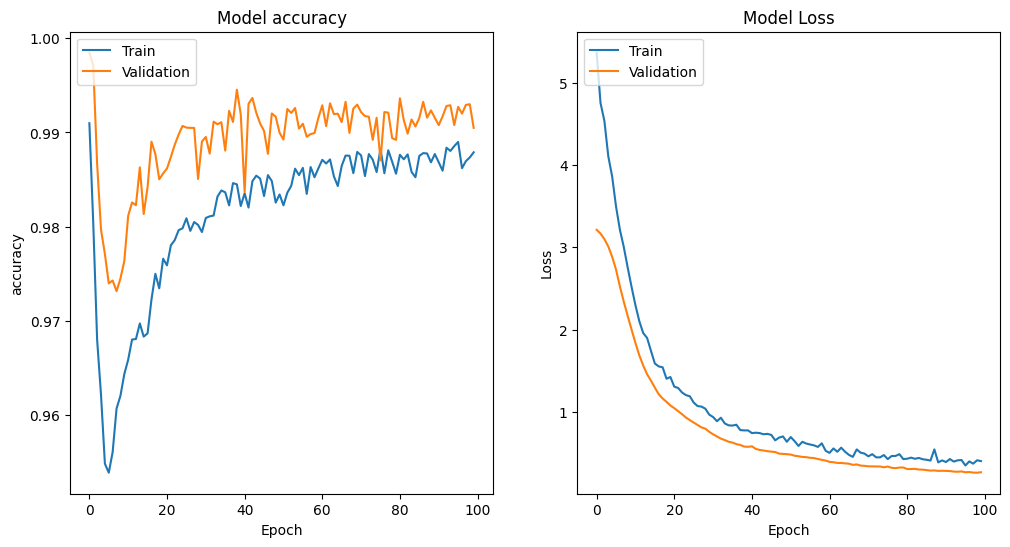

In [93]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [71]:
# Load JSON file
with open('encoding_maps.json', 'r') as file:
    encoding_maps = json.load(file)

In [94]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict probabilities on the test set
predictions = model.predict(X_test)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print detailed classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, predicted_classes, target_names=encoding_maps['target_map'].keys()))


30616/30616 ━━━━━━━━━━━━━━━━━━━━ 23s 754us/step - accuracy: 0.9905 - loss: 0.2674
Test Loss: 0.26726552844047546
Test Accuracy: 0.9904530644416809
30616/30616 ━━━━━━━━━━━━━━━━━━━━ 21s 682us/step
              precision    recall  f1-score   support

      normal       1.00      0.96      0.98    194689
         u2r       0.00      0.83      0.00        12
         dos       1.00      1.00      1.00    776508
         r2l       0.08      0.98      0.15       224
       probe       0.79      0.99      0.88      8254

    accuracy                           0.99    979687
   macro avg       0.57      0.95      0.60    979687
weighted avg       1.00      0.99      0.99    979687



In [95]:
model.save('models/NN_model.h5')  # Saves the model to HDF5 file

c:\Users\rizni\OneDrive\Desktop\KDDCUP\venv\Lib\site-packages\keras\src\models\model.py:342: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  warnings.warn(
